In [6]:
import sqlite3
import time
from IPython import display
from datetime import datetime
import scipy.interpolate as inter
from scipy import integrate

import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

In [7]:
db = sqlite3.connect('spectra.sqlite3')

In [71]:
def load_run(capture_id, gain, zero_cal=False):
    if zero_cal:
        data = db.execute('SELECT a.step, a.voltage, a.voltage_stdev, b.voltage, b.voltage_stdev '
               'FROM measurements a JOIN measurements b USING (step) '
               'WHERE a.capture_id = ?1 AND a.led_on = 1 AND b.capture_id = ?1 AND b.led_on = 0 '
               'ORDER BY step ASC', (capture_id,)).fetchall()
        steps, voltages, voltage_stdevs, zero_voltages, zero_stdevs = map(np.array, zip(*data))
    else:
        data = db.execute('SELECT step, voltage, voltage_stdev '
               'FROM measurements '
               'WHERE capture_id = ? AND led_on = 1 '
               'ORDER BY step ASC', (capture_id,)).fetchall()
        steps, voltages, voltage_stdevs = map(np.array, zip(*data))
        zero_voltages = zero_stdevs = np.zeros(len(steps))
        
    return (steps,
            (voltages-zero_voltages)/gain*1e9, # nanoamps
            np.sqrt(np.square(voltage_stdevs) + np.square(zero_stdevs))/gain*1e9) #nanoamps

In [94]:
def find_captures(name):
    # Get the newest capture for each color
    captures = db.execute(
        'SELECT capture_id, color, gain FROM runs WHERE (name, color, timestamp) IN '
        '(SELECT name, color, MAX(timestamp) FROM runs '
        'WHERE name=? GROUP BY color ORDER BY timestamp)', (name,)).fetchall()
    
    if not captures:
        raise ValueError('Run not found')
    return captures

In [95]:
def live_plot(name,
              spline_s=1, interval=1,
              live=True, save_svg=None):
    captures = find_captures(name)
    
    fig, ax = plt.subplots(1, 1)
    
    colors = {

    }
        
    while True:
        ax.clear()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_color('#08bdf9')
        ax.spines['left'].set_color('#08bdf9')
        ax.tick_params(axis='x', colors='#01769D')
        ax.tick_params(axis='y', colors='#01769D')
        ax.xaxis.label.set_color('#01769D')
        ax.yaxis.label.set_color('#01769D')
        ax.set_xlabel('$x\;[step]$')
        ax.set_ylabel('$I_{pd}\;[nA]$')
        ax.grid(color='#08bdf9', linestyle=':')
        
        for capture_id, color, gain in captures:
            color_dark, color_bright = colors.get(color, ('#fe3ea0', '#ffd2e9'))
            steps, values, stdev = load_run(capture_id, gain)
            
            ax.errorbar(steps, values, yerr=stdev, color=color_bright, zorder=1)
            try:
                spline = inter.UnivariateSpline(steps, values, s=spline_s)
                ax.plot(steps, spline(steps), color=color_dark, zorder=2)
            except:
                pass
        fig.canvas.draw()
        if save_svg:
            fig.savefig(save_svg)
        if save_svg or not live:
            break
        time.sleep(1)

<IPython.core.display.Javascript object>


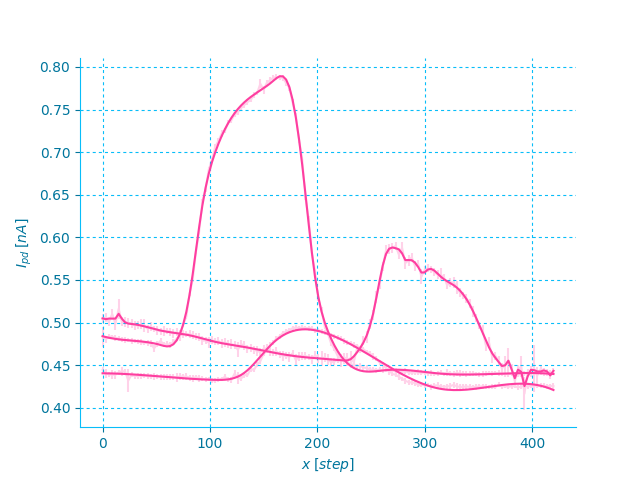

In [113]:
live_plot('cheap_rgb', spline_s=0.001, live=False, save_svg='/tmp/raw_plot_cheap_rgb.svg')

* Go further than step 250 to capture some zeros beyond the red band to allow the spline fitter to do its job more properly
* Move the entire screen further down and further increase range to properly capture blue rolloff
* Decrease amplification to avoid clipping. Maybe change amplification midway for green channel. Currenlty set to 5GOhm using 10M transimp feedback R with 1:10 T feedback and ~1:50 gain voltage amp stage. Maybe go back to plain transimp amp with 10M gain, for a total gain of 500M
* Decrease VGND bias to allow for more headroom

In [121]:
def plot_rgb_foo(data_rgb, ids_rgb, spline_s=1):
    fig, ax = plt.subplots(1, 1)
    fig.suptitle('Runs {}(R), {}(G), {}(B) at {:%y-%m-%d %H:%M:%S}'.format(*ids_rgb, datetime.now()))

    colors = [
        ((1,0,0), (1,0.8,0.8)),
        ((0,1,0), (0.8,1,0.8)),
        ((0,0,1), (0.8,0.8,1))
    ]
    for (steps, values, stdev), (color_dark, color_bright) in zip(data_rgb, colors):
        ax.errorbar(steps, values, yerr=stdev, color=color_bright)
        
        spline = inter.UnivariateSpline(steps, values, s=spline_s)
        ax.plot(steps, spline(steps), color=color_dark)

Poly for run 45: 2
2.282e-06 x - 0.001576 x + 0.4019
Poly for run 46: 2
6.886e-07 x - 0.0005388 x + 0.1561
Poly for run 44: 2
1.258e-06 x - 0.001514 x + 0.5252


<IPython.core.display.Javascript object>


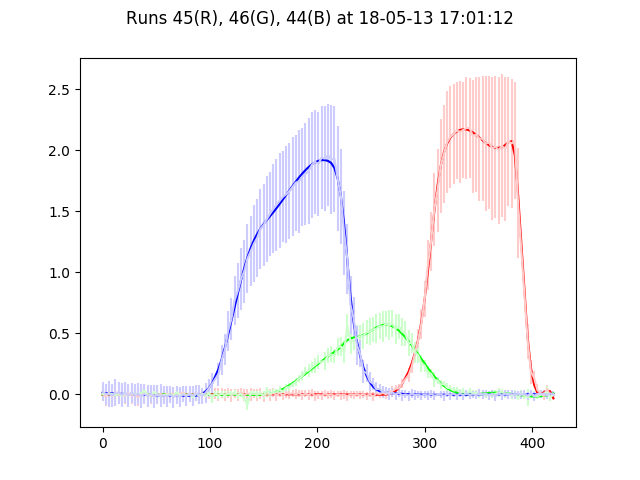

In [122]:
ids = (45, 46, 44)
bands = [(260,410), (150,330), (100,260)]
poly_degree = 2
max_stdev = 1.0
remove_thresh = 0.05

data_rgb = []
for run_id, (l, r) in zip(ids, bands):
    steps, values, stdev = load_run_zero_cal(run_id, max_stdev)
    
    idxs = (np.abs(stdev[1:-1] - stdev[0:-2]) < remove_thresh) |\
           (np.abs(stdev[1:-1] - stdev[2:]) < remove_thresh)
    idxs = np.hstack([np.array([True]), idxs, np.array([True])])
    steps, values, stdev = steps[idxs], values[idxs], stdev[idxs]
    
    idxs = (steps < l) | (steps > r)
    poly = np.poly1d(np.polyfit(steps[idxs], values[idxs], poly_degree))
    print('Poly for run {}: {}'.format(run_id, str(poly).strip()))
    
    values -= poly(steps)
    data_rgb.append((steps, values, stdev))

plot_rgb_foo(data_rgb, ids, spline_s=0.05)

In [97]:
def plot_rgb_calibrated(data_rgb, spline_s=1, save_svg=None):
    fig, ax = plt.subplots(1, 1)

    for steps, values, stdev in data_rgb:
        ax.errorbar(steps, values, yerr=stdev, color='#ffd2e9', zorder=1)
        
        spline = inter.UnivariateSpline(steps, values, s=spline_s)
        ax.plot(steps, spline(steps), color='#fe3ea0', zorder=2)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('#08bdf9')
    ax.spines['left'].set_color('#08bdf9')
    ax.tick_params(axis='x', colors='#01769D')
    ax.tick_params(axis='y', colors='#01769D')
    ax.xaxis.label.set_color('#01769D')
    ax.yaxis.label.set_color('#01769D')
    ax.grid(color='#08bdf9', linestyle=':')
    
    ax.set_xlim([380, 720])
    ax.set_xlabel('$\lambda\;[nm]$')
    ax.set_ylabel('$I_{pd}\;[nA]$')
    
    if save_svg:
        fig.savefig(save_svg)

<IPython.core.display.Javascript object>


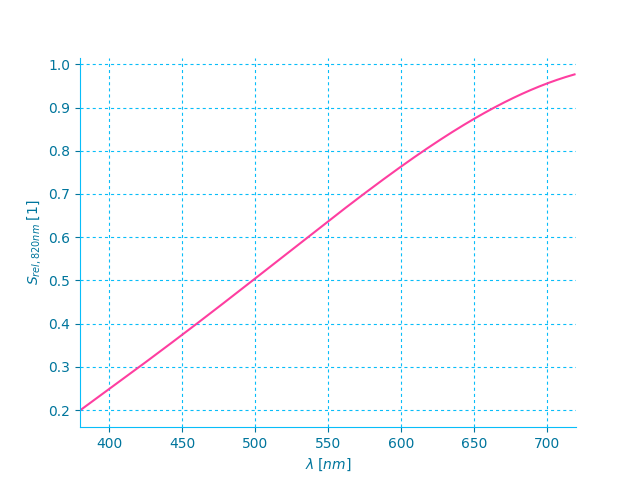

In [127]:
λ_sfh2701 = [ 300,  400,  500,  600,  700,  800,  900, 1000, 1100]
S_sfh2701 = [0.00, 0.20, 0.57, 0.76, 0.90, 1.00, 0.85, 0.37, 0.00]
Λ_sfh2701 = np.poly1d(np.polyfit(λ_sfh2701, S_sfh2701, 5))
r = np.arange(380, 720)
fig, ax = plt.subplots(1, 1)
ax.plot(r, Λ_sfh2701(r), color='#fe3ea0')
ax.set_xlim([380, 720])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('#08bdf9')
ax.spines['left'].set_color('#08bdf9')
ax.tick_params(axis='x', colors='#01769D')
ax.tick_params(axis='y', colors='#01769D')
ax.xaxis.label.set_color('#01769D')
ax.yaxis.label.set_color('#01769D')
ax.grid(color='#08bdf9', linestyle=':')

ax.set_xlim([380, 720])
ax.set_xlabel('$\lambda\;[nm]$')
ax.set_ylabel('$S_{rel,820nm}\;[1]$')
fig.savefig('/tmp/photodiode_sensitivity.svg')

Poly for red channel
 
-0.0001301 x + 0.4955
Poly for green channel
 
-3.846e-05 x + 0.4401
Poly for blue channel
 
-0.000189 x + 0.5092


<IPython.core.display.Javascript object>


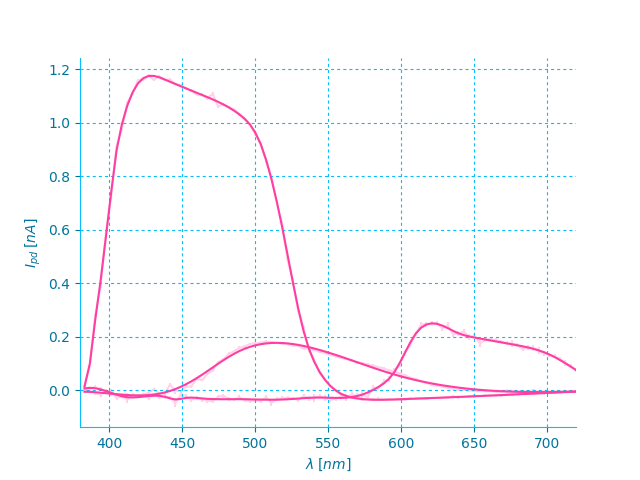

In [112]:
captures = find_captures('cheap_rgb')

# Approximate bands of interest for R, G and B channelsfor offset and stray light correction.
bands = {
    'red': (260,410),  # [step]
    'green': (150,330),
    'blue': (100,260)
}

# The wavelengths are from a random RGB LED datasheet and are just preliminary starting values.
# https://www.sparkfun.com/datasheets/Components/YSL-R596CR3G4B5C-C10.pdf
λ_led = {'red': 623, 'green': 518, 'blue': 466} # [nm] Assumed wavelengths of R, G and B spectral peaks.
λ_be = 400 # [nm] Approximate short-λ edge of blue band
y_edge_min = 0.5
transimpedance = 630e6 # Ohms.

poly_degree = 1 # degree of polynomial for stray light and offset correction. Should be 1 or 2.

#remove_thresh = 10.0 # [V] standard deviation delta threshold for outlier removal

# ---
data_rgb = {}
for capture_id, color, gain in captures:
    # Load this channel from the database
    steps, values, stdev = load_run(capture_id, gain)
    
    # Remove outlier values whose standard deviation is much larger than that of their right and left neighbors
    #idxs = (np.abs(stdev[1:-1] - stdev[0:-2]) < remove_thresh) |\
    #       (np.abs(stdev[1:-1] - stdev[2:]) < remove_thresh)
    #idxs = np.hstack([np.array([True]), idxs, np.array([True])])
    #steps, values, stdev = steps[idxs], values[idxs], stdev[idxs]
    
    # Remove offset and stray light by fitting a second-order polynomial over the parts of the curve
    # that are clearly *not* part of the primary peak.
    l, r  = bands[color]
    idxs = (steps < l) | (steps > r)
    poly = np.poly1d(np.polyfit(steps[idxs], values[idxs], poly_degree))
    print('Poly for', color, 'channel')
    print(poly)
    values -= poly(steps)
    
    data_rgb[color] = (steps, values, stdev)


# Produce a first estimate for wavelength scaling. Use the short-wavelength edge of the blue band and the red peak
# for this, as both can be assumed to remain stable even after photodiode response compensation. Then apply photodiode
# response compensation and do another, second round of wavelength scaling estimation but this time using all three
# peaks and a proper least-squares fit.
peaks  = { color: x[np.argmax(y)] for color, (x, y, σ2) in data_rgb.items() }
edgesl = { color: x[np.argmax(y > y_edge_min)] for color, (x, y, σ2) in data_rgb.items() }

Λ_est = np.poly1d(np.polyfit([edgesl['blue'], peaks['red']], [λ_be, λ_led['red']], 1))

data_tmp = { color: (x, Λ_est(x), y, σ2) for color, (x, y, σ2) in data_rgb.items() }
data_tmp = { color: (x, λ, y/Λ_sfh2701(λ), σ2) for color, (x, λ, y, σ2) in data_tmp.items() }
# Limit wavelength range
data_tmp = { color: (x[λ > 380], λ[λ > 380], y[λ > 380], σ2[λ > 380]) for color, (x, λ, y, σ2) in data_tmp.items() }

# Calibrate wavelength axis using assumed peaks for r, g and b. Use least-squares polyfit for getting coefficients.
peaks = { color: x[np.argmax(y)] for color, (x, λ, y, σ2) in data_tmp.items() }
Λ = np.poly1d(np.polyfit(
    [peaks['red'], peaks['green'], peaks['blue']],
    [λ_led['red'], λ_led['green'], λ_led['blue']], 1))

data_rgb = { color: (Λ(x), y, σ2) for color, (x, y, σ2) in data_rgb.items() }
data_rgb = { color: (λ, y/Λ_sfh2701(λ), σ2) for color, (λ, y, σ2) in data_rgb.items() }

# Limit wavelength range to slightly-larger-than visible range. We're getting improbably large values in the
# utraviolet region that are probably caused by stray light.
data_rgb = { color: (λ[λ > 380], y[λ > 380], σ2[λ > 380]) for color, (λ, y, σ2) in data_rgb.items() }

# Normalize amplitude data to brightest channel for ease of reading
#max_val = max(np.max(y) for λ, y, σ2 in data_rgb)
#data_rgb = [ (λ, y/max_val, σ2/max_val) for λ, y, σ2 in data_rgb ]

# Convert amplitude data to current in nanoampère
data_rgb = { color: (λ, y/transimpedance / 1e-9, σ2/transimpedance / 1e-9) for color, (λ, y, σ2) in data_rgb.items() }

plot_rgb_calibrated(data_rgb.values(), spline_s=0.005, save_svg='/tmp/processed_plot_cheap_rgb.svg')

In [114]:
# CIE XYZ Color matching functions from http://cvrl.ioo.ucl.ac.uk/
# rows are: λ[nm], x, y, z
CMFs = { fn[:-4]: np.genfromtxt(fn, delimiter=',')
        for fn in ['cie_xyz_1931.csv', 'cie_xyz_judd_1951.csv', 'cie_xyz_judd_vos_1978.csv'] }
CMFs = { name: np.hstack([inter.interp1d(d[:,0], d[:,i]) for i in range(1,4)])
        for name, d in CMFs.items() }

In [119]:
def integrate_tristimulus_response(data, channels=('red', 'green', 'blue'), colorspace='cie_xyz_1931'):
    a = np.array([[
        integrate.simps(
            np.multiply(CMFs[colorspace][j](data[color][0]), data[color][1]), data[color][0])
        for j in range(3) ]
        for color in channels ])
    # normalize by largest component
    return a / np.max(np.sum(a, axis=0))

In [120]:
tristimulus_data = integrate_tristimulus_response(data_rgb)
tristimulus_data
#array([[  3.46142003e-01,   1.73335974e-01,  -7.18827590e-05],
#       [  9.01721797e-02,   1.69512416e-01,   2.15830281e-02],
#       [  1.75128165e-01,   2.49230694e-01,   9.78488855e-01]])

array([[ 0.06995882,  0.02007191, -0.0260505 ],
       [ 0.05310356,  0.0995779 ,  0.03458726],
       [ 0.16122952,  0.16639874,  0.99146324]])

In [121]:
def led_setpoint_from_xyz(x, y, z):
    # returns [r, g, b] array.
    # Note that many xyz tristimulus values cannot be produced because one component is outside [0, 1]
    #return np.linalg.solve(tristimulus_data.T, np.array([x, y, z]))
    return np.dot(np.linalg.inv(tristimulus_data.T), np.array([x, y, z]))

In [122]:
led_setpoint_from_xyz(0.3, 0.2,  0.2)

array([ 2.96363627,  1.00231926,  0.24462504])